This notebook generates the images related to the synthetic elections generated by Mallows Models.

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_score

import sys
sys.path.append('..')
from Clustering_Functions import *

In [2]:
def Sil_scores(election, num_cands='Auto'):
    """
    returns the silhouette score of the k-means clustering of the given election for k=2,3,4,5.

    Returns: dictionary of silhouette scores for k=2,3,4,5 
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    X = np.array([Borda_vector(ballot, num_cands=num_cands) for ballot in election.keys()])
    sample_weight = np.array([election[ballot] for ballot in election.keys()])

    sil_scores = dict()
    for k in range(2,6):
        kmeans = cluster.KMeans(n_clusters=k, n_init = 200).fit(X,sample_weight=sample_weight)
        labels = kmeans.labels_
        sil_scores[k] = (silhouette_score(X,labels))   
    return sil_scores

In [10]:
def Mod_scores(election, num_cands = 'Auto'):
    """
    returns the modularity modularity-clustering of the given election for k=2,3,4,5 pieces.

    Returns: dictionary of moduarities for k=2,3,4,5 
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])

    mod_scores = dict()
    for k in range(2,6):
        C, mod = Modularity_cluster(election, k, num_cands=num_cands, graph = 'cast_ballots', method='greedy',return_modularity=True)
        mod_scores[k] = mod   
    return mod_scores

In [4]:
E1,C1 = Mallows_election(num_cands=9, num_clusters=1, centers=[[1,2,3,4,5,6,7,8,9]], sizes=[1000], p=.5)
E2,C2 = Mallows_election(num_cands=9, num_clusters=2, centers=[[1,2,3,4,5,6,7,8,9], [8,7,5,9,6,3,2,1,4]], 
                         sizes=[300, 700], p=.5)
E3,C3 = Mallows_election(num_cands=9, num_clusters=3, centers=[[1,2,3,4,5,6,7,8,9], [4,6,5,1,8,2,7,3,9], [7,8,9,4,5,6,3,2,1]],
                          sizes=[200, 200, 600], p=.5) 

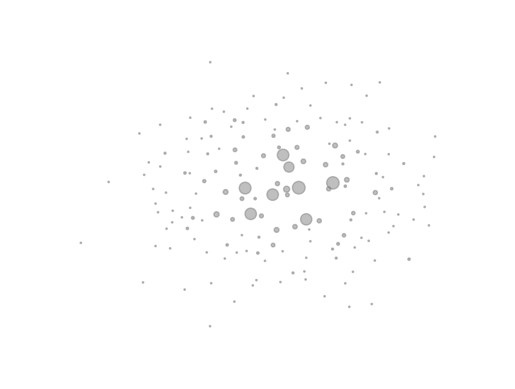

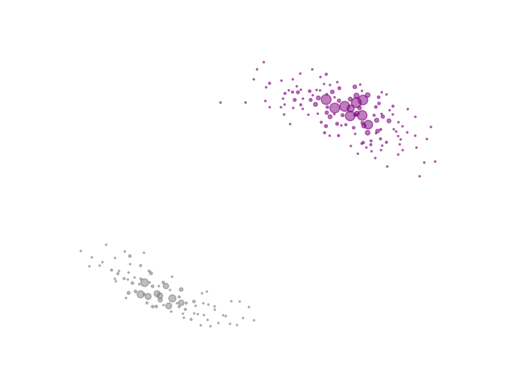

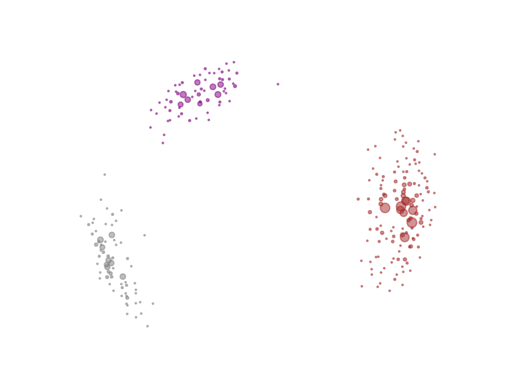

In [5]:
Ballot_MDS_plot(E1,C1, threshold = 1, filename = None)
Ballot_MDS_plot(E2,C2, threshold = 1, filename = None)
Ballot_MDS_plot(E3,C3, threshold = 1, filename = None)

In [11]:
S1 = Sil_scores(E1)
S2 = Sil_scores(E2)
S3 = Sil_scores(E3)
M1 = Mod_scores(E1)
M2 = Mod_scores(E2)
M3 = Mod_scores(E3)

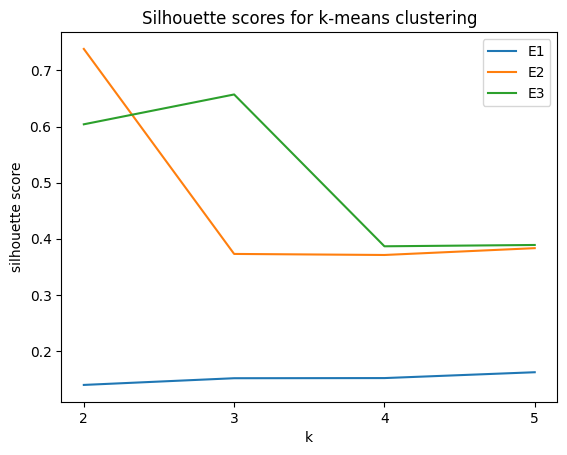

In [12]:
p_range = [2, 3, 4, 5]
plt.plot(p_range, [S1[k] for k in p_range], label='E1')
plt.plot(p_range, [S2[k] for k in p_range], label='E2')
plt.plot(p_range, [S3[k] for k in p_range], label='E3')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette scores for k-means clustering')
plt.legend()
plt.xticks(p_range)  # Set the tick marks at 2, 3, 4, and 5
#plt.savefig('Silhouette_vs_k.jpg', dpi = 600)
plt.show()

In [ ]:
p_range = np.arange(.02,.5,.02)
sil = []
mod = []
num_clusters = []

for p in p_range:
    election, C_truth = Mallows_election(num_cands=9, num_clusters=2, 
                          centers=[[1,2,3,4,5,6,7,8,9], [8,7,5,9,6,3,2,1,4]], sizes=[300, 700], p=p)
    C_mod, modularity = Modularity_cluster(election, graph = 'cast_ballots', method = 'greedy', return_modularity=True)
    C_kmeans = kmeans(election)
    mod.append(modularity)
    #print(p,modularity)
    num_clusters.append(len(C_mod))
    sil_scores = Sil_scores(election)
    sil.append(sil_scores)

In [46]:
num_clusters

[4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

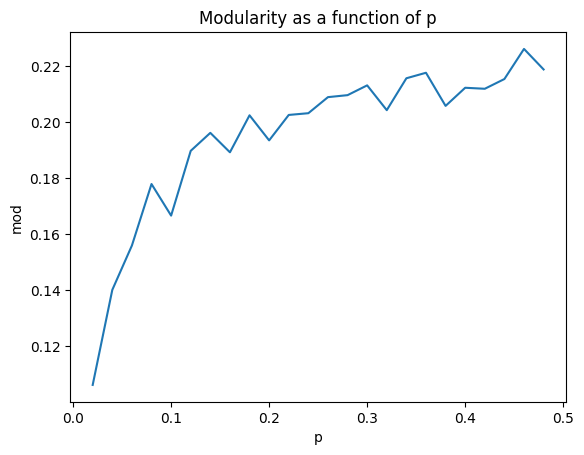

In [47]:
# Create the plot
plt.plot(p_range, mod)
plt.xlabel('p')
plt.ylabel('mod')
plt.title('Modularity as a function of p')
#plt.savefig('Modularity_vs_p.jpg')
plt.show()

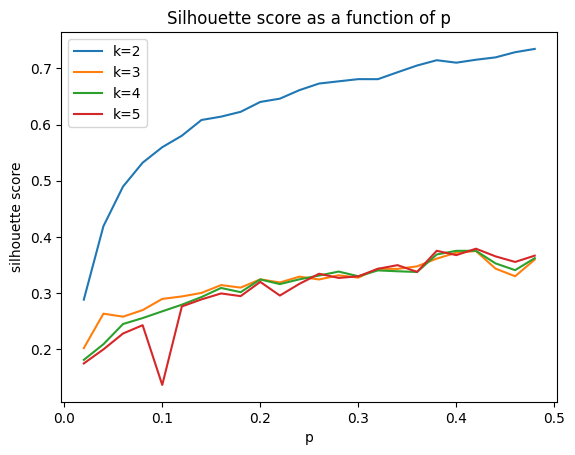

In [48]:
for k in range(2,6):
    plt.plot(p_range, [sil_scores[k] for sil_scores in sil], label=f'k={k}')
plt.xlabel('p')
plt.ylabel('silhouette score')
plt.title('Silhouette score as a function of p')
plt.legend()
#plt.savefig('Silhouette_vs_p.jpg')
plt.show()

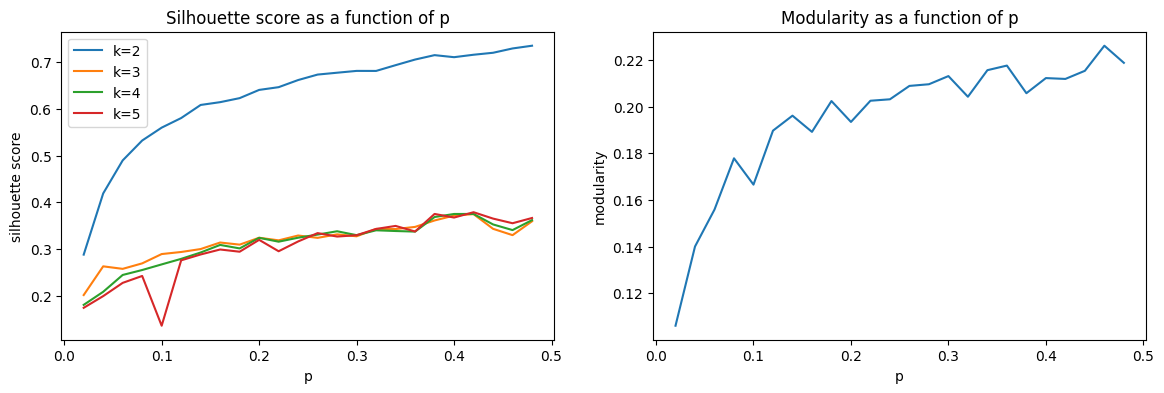

In [ ]:
# Display the previous two plots side by side
# Create a figure with two subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# FIRST PLOT
axs[1].plot(p_range, mod)
axs[1].set_xlabel('p')
axs[1].set_ylabel('modularity')
axs[1].set_title('Modularity as a function of p')

# SECOND PLOT
for k in range(2, 6):
    axs[0].plot(p_range, [sil_scores[k] for sil_scores in sil], label=f'k={k}')
axs[0].set_xlabel('p')
axs[0].set_ylabel('silhouette score')
axs[0].set_title('Silhouette score as a function of p')
axs[0].legend()

# Save the figure to a file
#plt.savefig('Mod_Sil.png')

# Show the plots
plt.show()